# Let's build GPT: from scratch, in code, spelled out

https://www.youtube.com/watch?v=kCc8FmEb1nY

GitHub repo: https://github.com/karpathy/ng-video-lecture

Goal of this final lecture is to create our own GPT. ChatGPT itself is a language model finishing input we provide. What's happening under the hood, modeling the sequence of words?

Generatively Pretrained Transformer - transformers come from 2017 paper [Attention is all you need](https://arxiv.org/abs/1706.03762)

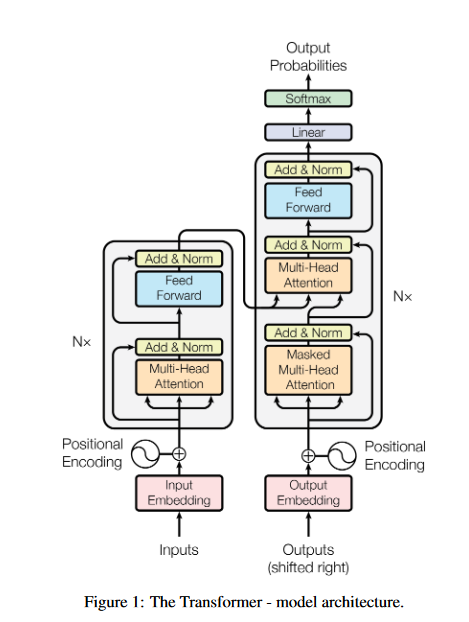

# Data and setup

Goal: train our own character-level data model using the complete works of Shakespeare (~1MB). Given some context, the transformer will look at a set of sequences and try to figure out what comes next.

Starter code contains 2 files, one defining the GPT architecture, and 1 training it.

In [1]:
# Read in the starting dataset

with open('ng-video-lecture/input.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


This is an ordered list of characters in the dataset; the entire set has 65 characters, starting with space, special characters, and then capitals and lowercase.

Need to tokenize the input text to an integer sequence that contains the vocabulary.

In [5]:
# create a mapping from characters to integers
# Simply iterates over character tablee printed above
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


More advanced tokenizers include e.g. SentencePiece which encodes sub-words and OpenAI uses tiktoken (used by their GPT). Have many more possible tokens; bigger codebook size for smaller sequence lengths. We'll use a simple character-level one with a small codebook for practice, resulting in long sequences.

In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

This just translates the dataset of text into a long sequence of integers. First 90% is the training data.

In [8]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


As before we'll set a block size, and train in batches. Recall that we'll train all the examples in the block at once. We get 8 training examples from the 8 character block, and 9th target. This gives the transformers the ability to predict with different levels of context, up to block_size.

Adding batches:

In [10]:
torch.manual_seed(1337) # for reproducibility
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # random offsets into the training set
    x = torch.stack([data[i:i+block_size] for i in ix]) # 
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [11]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


4 x 8 array contains 32 training examples. They're independent as far as the training process is concerned.

# Bigram model

Simplest version of a model would be to just use bigrams, as we did in the first lecture. Implementing directly in PyTorch:

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

# Take indices idx and pass them into the token embedding table
# Every integer refers to embedding table
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        return logits
    
m = BigramLanguageModel(vocab_size)
out = m(xb, yb)
print(out.shape)

torch.Size([4, 8, 65])


(B, T, C) = (4 = batch size, 8 = block size, 65 = vocab size)

Add definitions for loss.

`loss = F.cross_entropy(logits, targets)` won't work; need to specify the dimensionality

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

# Take indices idx and pass them into the token embedding table
# Every integer refers to embedding table
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        # loss = F.cross_entropy(logits, targets) won't work; need to specify the dimensionality
        B, T, C = logits.shape
        logits = logits.view(B*T, C) # stretches out tensor to 2D from 3D
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

        return logits, loss
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


Higher loss than before which isn't surprising given a larger vocab size. Expected loss on an untrained model is:

$ -ln(1/65) \approx 4.17 $

So we have bad initial predictions but the loss evaluation function works.

Last piece is a model generation function.

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# start with zeros tensor (newline in this case) to kick off generator
idx = torch.zeros((1, 1), dtype=torch.long)
# generate max of 100 tokens
max_new_tokens=100
# index to [0] row to "unplug" single batch dimension, then feed it to a list and pass to decode function we created
print(decode(m.generate(idx, max_new_tokens)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


This is nonsense because the model isn't yet trained. That's the next step.

The code is very inefficient for a bigram model (why look at previous context when only 1 letter is used for prediction) but this will be used for the more complex model.

Create a PyTorch optimizer using AdamW, better than SGD.

In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [16]:
batch_size = 32
for steps in range(100): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    print(loss.item())


4.704006195068359
4.721118927001953
4.653193473815918
4.706261157989502
4.780904293060303
4.751267910003662
4.8395490646362305
4.667973041534424
4.743716716766357
4.774043083190918
4.6908278465271
4.789143085479736
4.61777925491333
4.650947093963623
4.886447429656982
4.703796863555908
4.757591724395752
4.65510892868042
4.709283828735352
4.6745147705078125
4.760501384735107
4.7892632484436035
4.653748512268066
4.6619181632995605
4.673007488250732
4.66577672958374
4.7301106452941895
4.755304336547852
4.712186813354492
4.745501518249512
4.726755619049072
4.735108375549316
4.777461051940918
4.643350601196289
4.6651835441589355
4.79764461517334
4.717412948608398
4.683647155761719
4.81886100769043
4.613771915435791
4.573785781860352
4.560741901397705
4.81563138961792
4.6061553955078125
4.619696140289307
4.725419521331787
4.650487899780273
4.5941481590271
4.7202863693237305
4.699342250823975
4.6724138259887695
4.727972984313965
4.66152286529541
4.616766929626465
4.599857807159424
4.6533403396

Clearly something is happening - loss went down noticeably in the first 100 iterations.

Try more training, in batches of 1000.

In [17]:
batch_size = 32

for _ in range(10):
    for steps in range(1000): # increase number of steps for good results... 
        
        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = m(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    print(loss.item())


3.6380467414855957
3.108039140701294
2.8381073474884033
2.7120282649993896
2.4290480613708496
2.385906219482422
2.4341988563537598
2.3517558574676514
2.594815731048584
2.4522740840911865


Mid 2 range is about where the original bigram model was. Output should look less random.

In [18]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


DUKIVisun Casshe wisthiot s.
LUK:

NGOLI io e alllker s?j$NCowens l het hislaspicobar, heay ind, cigigeluandac! thaforo nont
SLO:
Ange ive nn I ou m,
UCENTheanp'Lbet bazzl
TEEXNore t b'Thathon:
sous min'd ne st wousis s lingilo whee,
K:
Toow'e's,
D:
NGLEng, do te! ase may sin ceecate.
God? d
Aw ht hongur vet ouley, tonches s ousour mes o be angaxHatiminthafe atnt ur whis heand ay out sitourdy spehacugnting akefo tofed werore mo d htreldeg ise se inon ime weagsone the kener bs s oweclishentens t 


Yeah, definitely starting to look more Shakespeare though still not good.

# Scripted training

Next step: convert bigram model to a script, `bigram.py` (taken from github repo).

Uses various speed-up tricks, like doing training on cuda cores if available, which will be much faster. Also torch.no_grad() and giving context like setting model.train() and model.test() where appropriate.

# Self-attention

In [19]:
# consider the following toy example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

We want to have the up to 8 tokens in a batch to be coupled and "talk" to each other. 5th location token should see 1-4 but not 6-8. Information flows form previous to current timeslot.

Simplest way to get past info is take an "average" of vectors of previous tokens, and this one.

In [20]:
# We want x[b,t] = mean_{i<=t} x[b,i]
# bow = bag of words
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [21]:
print(x[0])
print(xbow[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


Note in 2nd tensor, each subsequent row is average of the preceding ones. It works but is inefficient.

Instead, let's use matrix multiplication - much faster.

In [22]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
# torch.tril is the lower triangular part of the matrix
# [[1,0,0],[1,1,0],[1,1,1]]
a = torch.tril(torch.ones(3, 3))
# Normalize all rows so they sum to 1
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Note that the first row of $a$ returns 1st element, 2nd row is average of first 2, third row is average of all 3, etc.

Implementing:

In [23]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
# wei is (T, T) but gets B appended due to dimensionality of x
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

print(xbow[0])
print(xbow2[0])

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


Another version: use softmax.

wei starts as all 0; what masked_fill does is make all 0 elements -inf. Taking softmax along every row, we get same matrix.

In [24]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

In [25]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


The softmax version is what we'll actually use for self attention. Start with 0, and the -inf says don't look at the future. Softmax will allow values to change so previous elements are more or less interesting to one another; not just a straight average.

Final version: don't initialize weights to be all 0. Similar rationale to weight initialization for other NN models. Want information to flow based on the data, e.g. if there's a vowel maybe consonants should be higher weighted.

Self-attention solves this: each node emits two vectors: query, and key. Query vbector is "what's being looked for" and key vector is "what's contained" - do dot product between keys and queries to create new weights.

In [26]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# Dot product between queries and keys
# Every row of B has a TxT matrix of the affinities
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei replaced by the dot product above
#wei = torch.zeros((T,T))
# This step ensures "future" information doesn't leak
wei = wei.masked_fill(tril == 0, float('-inf'))
# This normalizes the row
wei = F.softmax(wei, dim=-1)

# Don't use raw x, aggregate to v
v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [27]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Now each batch element has its own tokens for wei. The weights are no longer uniform; each token has their own query and the matrices get updated during training.

Conceptually attention is a directed graph - passing information between nodes. Our graph would have loops, with 1 pointing to itself, 2 pointed to by 1 and 2, etc. but in principle attention supports arbitrarily connected graphs.

From Andrej's notes:

*    Attention is a communication mechanism. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
*    There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
*    Each example across batch dimension is of course processed completely independently and never "talk" to each other
*    In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
*    "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
*    "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [28]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
# -sqrt(head_size) is the correction
wei = q @ k.transpose(-2, -1) * head_size**-0.5

print("head size =", head_size)
print((q @ k.transpose(-2, -1)).var())
print(wei.var())

head size = 16
tensor(17.4690)
tensor(1.0918)


Note without the correction factor of $\frac{1}{\sqrt{headsize}}$ the variance is proportional to `head_size` and i0t's important to initialize wei near 0 since there's a softmax. We don't want particularly extreme values because they get pushed to -1 or 1 by softmax; same issue seen initializing parameters in other networks.

See `Head` class in gpt.py for implementation. In the language model the head is created by the constructor.

# Self-attention model

Train a model with the new elements.

In [31]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32
# ------------

torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        #wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa_head(x) # apply one head of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


step 0: train loss 4.2000, val loss 4.2047
step 500: train loss 2.6911, val loss 2.7087
step 1000: train loss 2.5196, val loss 2.5303
step 1500: train loss 2.4775, val loss 2.4829
step 2000: train loss 2.4408, val loss 2.4523
step 2500: train loss 2.4272, val loss 2.4435
step 3000: train loss 2.4130, val loss 2.4327
step 3500: train loss 2.3956, val loss 2.4212
step 4000: train loss 2.4041, val loss 2.3992
step 4500: train loss 2.3980, val loss 2.4084


In [32]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Whent iknt,
Thowi, ht son, bth

Hiset bobe ale.
S:
O-' st dalilanss:
Want he us he, vet?
Wedilas ate awice my.

HDET:
ANGo oug
Yowhavetof is he ot mil ndill, aes iree sen cie lat Herid ovets, and Win ngarigoerabous lelind peal.
-hule onchiry ptugr aiss hew ye wllinde norod atelaves
Momy yowod mothake ont-wou whth eiiby we ati dourive wee, ired thoouso er; th
To kad nteruptef so;
ARID Wam:
ENGCI inleront ffaf Pre?

Wh om.

He-
LIERCKENIGUICar adsal aces ard thinin cour ay aney Iry ts I fr af ve y


Small but somewhat apparent improvement from before. Next step is multi-head attention, mutliple heads in parallel.

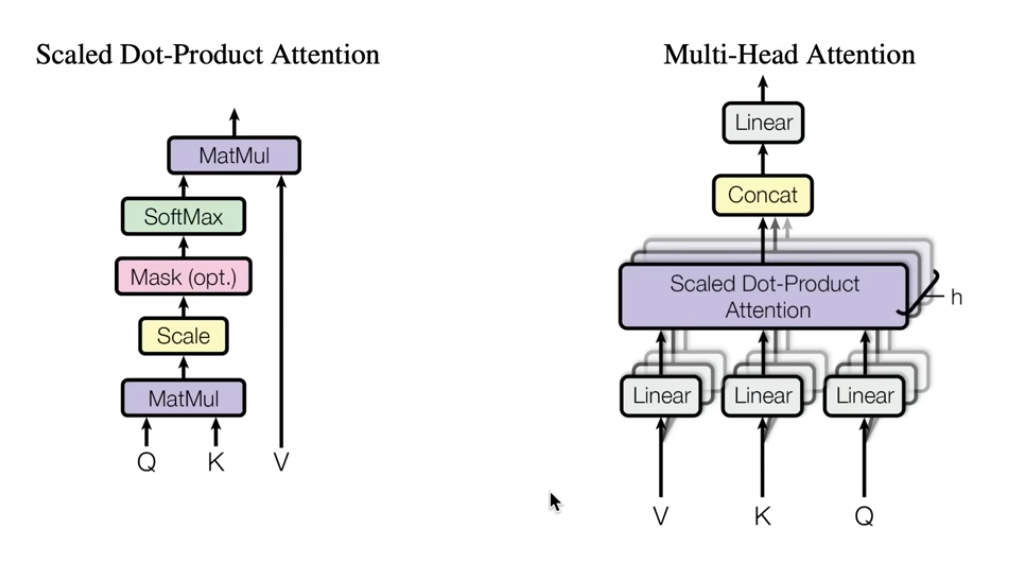

In [33]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim = -1)

Instead of 1 communication channel there are now 4 in parallel, 8 dimensional heads of self-attention.

Apparently similar to group convolution.

In [34]:
torch.manual_seed(1337)

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa_heads(x) # apply one head of self-attention. (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.2227, val loss 4.2226
step 500: train loss 2.6592, val loss 2.6733
step 1000: train loss 2.4980, val loss 2.5064
step 1500: train loss 2.4291, val loss 2.4349
step 2000: train loss 2.3716, val loss 2.3844
step 2500: train loss 2.3417, val loss 2.3561
step 3000: train loss 2.3149, val loss 2.3347
step 3500: train loss 2.2918, val loss 2.3171
step 4000: train loss 2.2895, val loss 2.2868
step 4500: train loss 2.2748, val loss 2.2858


In [35]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Whent if bridcowd, whis byer that set bobe toe anthr-and mealleands:
Warth foulque, vet?
Wedtlay anes wice my.

HDY'n om oroug
Yowns, tof is heir thil; dill, aes isee sen cin lat Hetilrov the and Win now onderabousel.

SFAUS:
Shenser cechiry prugh aissthe, ye wing, u not
To thig I whomeny wod mothake ont---An hat evibys wietit, stile weeshirecs poor gier; to
To k danteref If sor; igre! mef thre inledo the af Pre?

WISo myay I sup!
Atied is:
Sadsal the E'd st hoin couk aar tey Iry to I frouf voul


Passed the 2.3 validation loss mark. Having multiple channels helps because there's lots of communication that can be used by the tokens: consonants, vowels, strings of consonants, etc. Helps to have more types of data and decoding the output.

# Additional optimization: feed forward, skip connections, layernorm

Can add feed forward parts to complexify the model. Logits step should incorporate what's learned from the other tokens.

In [36]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [37]:
torch.manual_seed(1337)

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        # New feed forward layer
        self.ffwd = FeedFoward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.sa_heads(x) # apply one head of self-attention. (B, T, C)
        # New step to use feed forward layer
        x = self.ffwd(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.1996, val loss 4.1995
step 500: train loss 2.5993, val loss 2.6077
step 1000: train loss 2.4629, val loss 2.4651
step 1500: train loss 2.3974, val loss 2.3951
step 2000: train loss 2.3297, val loss 2.3470
step 2500: train loss 2.3018, val loss 2.3221
step 3000: train loss 2.2828, val loss 2.2936
step 3500: train loss 2.2495, val loss 2.2721
step 4000: train loss 2.2435, val loss 2.2468
step 4500: train loss 2.2286, val loss 2.2411


Self-attention is communication, then the feed forward layer is acting on each token individually. "Communication" and "rumination" steps.

This is even better validation loss.

In [38]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


And the Ror
Thow and is and thrad thom obe to tarver-' my dall and bar hiphe us hat tot?
Wedtlacoate aw crup and not, ut onoth
Yowns, tof it he cove lend lincath is ees, hain lat Het dulvets, and to poman is wables lill dite ullliser cecrivy prupt aiss hew youn's and knamopetell lownomthy wod moth keacal---A wher eiicks to thour rive cees ineds pood of he thu the hanterth fo so;; igis! my to thy ale ontat af Pried my of.
WHINY ICHARD:
Poid:
Ardsal the Eget to uin cour ay andy Rry to chan the!
An


Looks like we've achieved Beowulf.

We've basically finished a single block in the architecture, interspersing communication and computation.

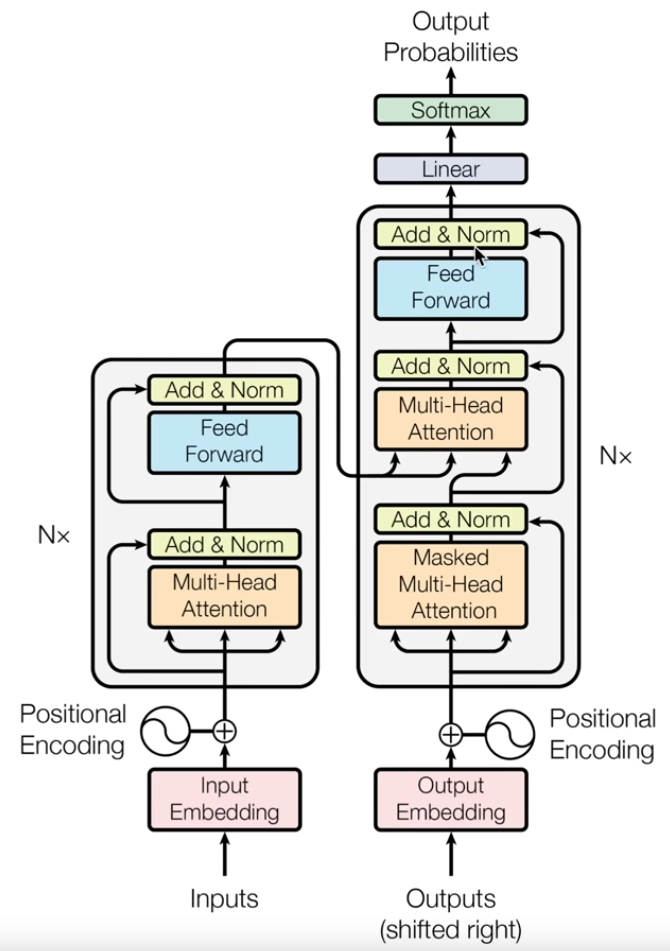

Can further improve the model by having more blocks before decoding. But just doing this sequentially:

`Block(n_embd, n_head = 4)`

will not lead to a good result because the network is getting deep which can cause optimization issues.

First optimization: residual connections, or skip connections, are the skip layer arrows on the right. Add data from previous features.

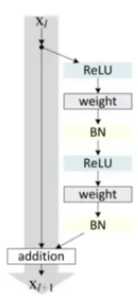

During backpropagation, recall that addition distributes the gradiant equally. So gradients from the loss move directly to the input unimpeded, while also traveling through the complicated blocks. During optimization these blocks "come online" over time as they're trained. In practice this helps a lot with optimization.

In [39]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        # Fork for communication
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        
    def forward(self, x):
        # Fork for computation
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x
    
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        # Need to apply projection rather than taking result directly
        #return torch.cat([h(x) for h in self.heads], dim = -1)
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out)
        return out
    
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            # Multiplying by 4 is from another paper; add more complexity in layer before projecting back into residual pathway
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            # New projection layer into residual pathway
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


In [40]:
torch.manual_seed(1337)

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        """self.sa_heads = MultiHeadAttention(4, n_embd//4) # i.e. 4 heads of 8-dimensional self-attention
        # New feed forward layer
        self.ffwd = FeedFoward(n_embd)"""
        self.lm_head = nn.Linear(n_embd, vocab_size)
        # Use blocks
        self.blocks = nn.Sequential(
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
        )

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        """x = self.sa_heads(x) # apply one head of self-attention. (B, T, C)
        # New step to use feed forward layer
        x = self.ffwd(x) # (B, T, C)"""
        # Use blocks
        x = self.blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.5359, val loss 4.5289
step 500: train loss 2.3860, val loss 2.3790
step 1000: train loss 2.2675, val loss 2.2748
step 1500: train loss 2.1865, val loss 2.2090
step 2000: train loss 2.1410, val loss 2.1819
step 2500: train loss 2.0987, val loss 2.1545
step 3000: train loss 2.0674, val loss 2.1493
step 3500: train loss 2.0581, val loss 2.1237
step 4000: train loss 2.0301, val loss 2.1213
step 4500: train loss 2.0121, val loss 2.1174


In [41]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


And they bridce.

STAR OF God madisel bube don.
Say the let galauss:
Warthis us hath bubar dilad anes with my fears a um onouge owns, to fiste be this now
Whiges if eesent, mild is the overs, and the now me you musel.
Hord, and thuse conce:
The priness hew ye with as nor
To this dewer:
Give, the make on in on her evicks the modistion wees in he pooks: the me
To kind thrugh for are
The would with aled, the sad
Ride my of.

HENRY ERIONGSENY:
Wards be his grest hoig courrear tey vey to chan you!
My


We've achieved some recognizable English words. Perhaps a bit of overfitting by the end; note how training loss is ~5% below validation loss.

Finally, we can implement layernorm (similar to batchnorm) to make sure rows are unit Gaussian, rather than individual neurons.

$ y = \frac{x - E(x)}{\sqrt{\text{Var}(x)+\epsilon}} * \gamma + \beta $

Compared to the old BatchNorml algorithm, there aren't any running buffers or training/test distinction.

In [42]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    # before first arg was 0, instead of 1
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [43]:
print(x[:, 0].mean(), x[:, 0].std()) # mean, std of one feature across all batch inputs
print(x[0, :].mean(), x[0, :].std()) # mean, std of a single input from the batch, of its features

tensor(0.1469) tensor(0.8803)
tensor(-9.5367e-09) tensor(1.0000)


Columns themselves aren't normalized, but the rows are normalized for each example.

Unlike original paper schematic, our norm layer takes place during the block not after.

In [44]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        # Fork for communication
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        # LayerNorm step
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        # Fork for computation
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [45]:
torch.manual_seed(1337)

# Bigram model from before
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        # Use blocks
        self.blocks = nn.Sequential(
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
            Block(n_embd, n_head = 4),
            # Add an additional LayerNorm at the end
            nn.LayerNorm(n_embd),
        )

    # Add targets default = None to avoid errors
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # logits = self.token_embedding_table(idx) # (B,T,C)
        B, T = idx.shape

        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,  C)
        x = tok_emb + pos_emb # (B, T, C)
        # Use blocks
        x = self.blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    # max_new_tokens allows for continuous generation, up to the provided maximum
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            # creates a running stream of integers
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.3022, val loss 4.2980
step 500: train loss 2.4074, val loss 2.4001
step 1000: train loss 2.2659, val loss 2.2704
step 1500: train loss 2.1773, val loss 2.2022
step 2000: train loss 2.1282, val loss 2.1644
step 2500: train loss 2.0813, val loss 2.1334
step 3000: train loss 2.0514, val loss 2.1211
step 3500: train loss 2.0448, val loss 2.1014
step 4000: train loss 2.0115, val loss 2.0905
step 4500: train loss 1.9923, val loss 2.0819


In [46]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))



Clongect
Tidle?

SO O lay be madisencural a eyarther'd the gatalss:
Warthy pustart to bardetlessay, away, my facks a wizy mus
Yout Latefting come milendill, at miree:
Youch that Hellardvers, and the now on that spelplind me lielved, on him comer; and all, you lord.
In amoperelives
Momery would thake only so what evily well most rive cenchired thou more-fore
To kind thrufe for are
gret must with allood, forfe
Then my of.

HENNLIES:
With is a adall as sould my din courray, tey If-lisglown af voly


Canterbury Tales level achieved.



# Dropout and final model

This model is already pretty much a complete transformer, and we can scale up the model to see how good things can get.

One more optimization is to add the concept of dropout. Can add it right before the residual cennection, randomly preventing some nodes from communicating. Every forward/backward pass a subset of neurons is masked; every forward/backward pass ends up training an ensemble of subnetworks, then at test time all are used together. In practice this helps a lot with overfitting.

(Sounds like ensemble modeling to me.)

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(torch.cuda.current_device()))
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
0
NVIDIA GeForce RTX 2060 SUPER


In [2]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 128 #256 # what is the maximum context length for predictions? MUCH higher than normal
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4 # lower learning rate since it's a much bigger model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 192 #384 # every head is 64 dimensions
n_head = 6
n_layer = 6
dropout = 0.2 # disable 20% of neurons every pass
# ------------

torch.manual_seed(1337)
"""
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
"""
with open('ng-video-lecture/input.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


2.715713 M parameters
step 0: train loss 4.2444, val loss 4.2426
step 100: train loss 2.5191, val loss 2.5199
step 200: train loss 2.4060, val loss 2.4198
step 300: train loss 2.2963, val loss 2.3200
step 400: train loss 2.0996, val loss 2.1460
step 500: train loss 1.9434, val loss 2.0363
step 600: train loss 1.8094, val loss 1.9304
step 700: train loss 1.7233, val loss 1.8696
step 800: train loss 1.6640, val loss 1.8332
step 900: train loss 1.6135, val loss 1.7882
step 1000: train loss 1.5806, val loss 1.7604
step 1100: train loss 1.5426, val loss 1.7236
step 1200: train loss 1.5142, val loss 1.7074
step 1300: train loss 1.4940, val loss 1.6746
step 1400: train loss 1.4732, val loss 1.6608
step 1500: train loss 1.4541, val loss 1.6528
step 1600: train loss 1.4359, val loss 1.6359
step 1700: train loss 1.4254, val loss 1.6284
step 1800: train loss 1.4071, val loss 1.6210
step 1900: train loss 1.3998, val loss 1.6041
step 2000: train loss 1.3810, val loss 1.5939
step 2100: train loss 1.

Great validation loss (albeit still overfit), but I'd expect that with the number of parameters. This is about 1/4 the size of Andrej's final model (>10M parameters) and trained in ~14 minutes.

In [3]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


As my lord!
What doth fellows not? what, I have my royal best
Elevouh with rest, host all thou many dear may
Peace have the winger of our tent.
to heave meet, a grief, he most nine;
For show but no more good to sist;
Foul need, more hence; open mockine, but it by oath,
The doth eyes was, and think off cause;
even will to set the wanies of lights of hes death,
And sleep here stways, here a way meating born?
Shall I am many enouns the less; diss foot once:
Bellows I than nosins for parts itseable.


In [4]:
open('more-shakespeare.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10001

Good stuff.

# Final thoughts

We implemented a decoder only transformer; there is no encoder, or cross-attention block. Additonal blocks could be used for things like language translation - encoder would work on entire sentence, not a triangular piece like we did.

See [nanoGPT](https://github.com/karpathy/nanoGPT) for a cleaned up repo with some additional features.

How would training ChatGPT ourselves look like what we learned today?

1) pretraining stage
2) fine-tuning stage

Pre-training stage involves training on large chunk of internet to get a transformer that babbles text. ChatGPT uses about 50,000 elements, unlike us; we had a vocabulary of 64 and a few hundred thousand tokens. My model had 2.7M parameterse and 6 layers. Compare to ChatGPT:

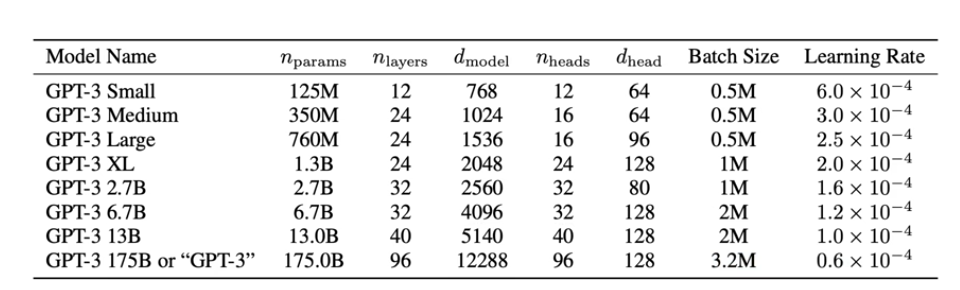

After pretraining stage we have a document completer. A question could result in more questions, or whatever else some document in your training data might look like.

The fine-tuning stage creates an assistant, as described on the [OpenAI blog](https://openai.com/blog/chatgpt). Train desired output on question above, answer below format. Then create a reward model (with help from labelers) and use a reinforcement learning algorithm to further fine-tune the model to generate acceptable answers.